#Install libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install torchtext --upgrade --q
    !pip install torchmetrics --q
    !pip install --quiet torch-lr-finder --q
    !pip install wandb --q --upgrade

    basepath = '/content/drive/MyDrive/NLP_UTD/Assignments/Assignment_7'
    sys.path.append('/content/drive/MyDrive/NLP_UTD/custom-functions')
    
else:
    basepath = '/home/harpreet/Insync/google_drive_shaannoor/data'
    sys.path.append('/home/harpreet/Insync/google_drive_shaannoor/data/custom-functions')   

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from pathlib import Path
base_folder = Path(basepath)
data_folder = base_folder
model_folder = base_folder
custom_functions = '/content/drive/MyDrive/NLP_UTD/custom-functions'
# sys.path.append(str(custom_functions))
sys.path

['/content',
 '/env/python',
 '/usr/lib/python39.zip',
 '/usr/lib/python3.9',
 '/usr/lib/python3.9/lib-dynload',
 '',
 '/usr/local/lib/python3.9/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.9/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/NLP_UTD/custom-functions']

In [4]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F


import torchmetrics
from torchmetrics.classification import Accuracy

import random
import numpy as np
import joblib

from types import SimpleNamespace
from functools import partial
from pathlib import Path
import sys
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

import wandb

from torch_lr_finder import LRFinder
from Trainer_v4 import Trainer
from data_preparation_HW7 import *
from ff_sequential_model import MLPCustom

/usr/local/lib/python3.9/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
Trainer.set_seed()
df = joblib.load(data_folder/'df_multilabel_hw_cleaned.joblib')

In [6]:
import ast
df['Tag_Number'] = df['Tag_Number'].apply(ast.literal_eval)
print(type(df['Tag_Number'][0][1]))

<class 'int'>


In [7]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
one_hot = mlb.fit_transform(df['Tag_Number'])
df['Tags_Encoded'] = pd.Series(one_hot.tolist())
X_train_cleaned = df['cleaned_text'].values
y_train = df['Tags_Encoded'].values

In [8]:
trainset = CustomDataset(X_train_cleaned, y_train)
train_subset_indices = random.sample(range(0, len(trainset)), 500)
train_subset = torch.utils.data.Subset(trainset, train_subset_indices)
multilabel_vocab = get_vocab(trainset, min_freq=2)

In [9]:
from gensim.models import KeyedVectors
cbow_vectors_HW7 = KeyedVectors.load(str(base_folder/'cbow_model_AJ.bin'))
pretrained_weights_tensor, words_found, words_not_found = get_pretrained_weights(multilabel_vocab, cbow_vectors_HW7)

In [26]:
hyperparameters = SimpleNamespace(
    # for model
    EMBED_DIM=300,
    VOCAB_SIZE=len(multilabel_vocab),
    OUTPUT_DIM=10,
    HIDDEN_SIZES_LIST=[],
    DPROB_LIST=[],
    NON_LINEARITY=nn.SELU(),
    BATCH_NORM=False,
    
    # for optimizer
    OPTIMIZER="SGD",
    MOMENTUM=0,
    NESTEROV=False,
    
    # for training
    INITIALIZATION="default",
    EPOCHS=20,
    BATCH_SIZE=32,
    LEARNING_RATE=0.001,
    DATASET="Multilabel",
    ARCHITECTURE="emdbag_linear",
    
    # Schedulers
    SCHEDULER="None",
    USE_PRE_TRAINED_WEIGHTS=True,
    PRETRAINED_WEIGHTS=pretrained_weights_tensor,
    FREEZE_PRETRAINED=False,

)

In [72]:
# Variables
project_name = "HW7_overfit_small_multilabel_v1"
run_name = "exp4"
run_folder = model_folder / run_name
run_folder.mkdir(exist_ok=True)
log_frequency = 5

In [73]:
# # run 1 - based on default initialization
# # Notes: Final Learning rate was set to 1

# # run 2
# hyperparameters.HIDDEN_SIZES_LIST = [200]
# hyperparameters.DPROB_LIST = [0]
# hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# # Notes : Final Learning rate was set to 2.26E+00

# # run 3
# hyperparameters.OPTIMIZER = "Adam"
# hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# # Notes : Final Learning rate was set to 3.43E-02

# run 4
hyperparameters.HIDDEN_SIZES_LIST = [200] + [200]
hyperparameters.DPROB_LIST = [0] + [0]
hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# Notes : Final Learning rate was set to 9.77E-01

# # run 5
# hyperparameters.INITIALIZATION = 'kaiming'
# hyperparameters.NON_LINEARITY = nn.ReLU()
# hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# # Notes : Final Learning rate was set to 1.87E+00

# # run 6
# hyperparameters.HIDDEN_SIZES_LIST = [400] 
# hyperparameters.DPROB_LIST = [0] 
# hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# # # Notes : Final Learning rate was set to 1.56E+00

In [74]:
# Fix seed value
Trainer.set_seed()

collate_fn = partial(collate_batch, vocab=multilabel_vocab)

# Data Loader
train_loader, _ = get_loaders(
    trainset=train_subset,
    validset=None,
    batch_size_=hyperparameters.BATCH_SIZE,
    collate_fn=collate_fn,
)

# cross entropy loss function
loss_function = nn.BCEWithLogitsLoss()

# model
model_multilabel_hw7 = MLPCustom(
    hyperparameters.EMBED_DIM,
    hyperparameters.VOCAB_SIZE,
    hyperparameters.HIDDEN_SIZES_LIST,
    hyperparameters.DPROB_LIST,
    hyperparameters.OUTPUT_DIM,
    hyperparameters.NON_LINEARITY,
    hyperparameters.BATCH_NORM,
    # hyperparameters.USE_PRE_TRAINED_WEIGHTS,
    # hyperparameters.PRETRAINED_WEIGHTS,
    # hyperparameters.FREEZE_PRETRAINED,
)


def init_weights(m):
    if type(m) == nn.Linear: 
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

# apply initialization recursively  to all modules
if hyperparameters.INITIALIZATION == 'kaiming':
    model_multilabel_hw7.apply(init_weights)


# OPTIMIZERS
def get_optimizer():
    if hyperparameters.OPTIMIZER == "SGD":
        optimizer = torch.optim.SGD(
            model_multilabel_hw7.parameters(),
            lr=hyperparameters.LEARNING_RATE,
            momentum=hyperparameters.MOMENTUM,
            nesterov=hyperparameters.NESTEROV,
        )
    else:
        optimizer = torch.optim.Adam(
            model_multilabel_hw7.parameters(), lr=hyperparameters.LEARNING_RATE
        )
    return optimizer


optimizer = get_optimizer()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [75]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [76]:
model_multilabel_hw7

MLPCustom(
  (non_linearity): ReLU()
  (embedding): EmbeddingBag(152172, 300, mode='mean')
  (module_list): ModuleList(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [77]:
trainer = Trainer(
    model=model_multilabel_hw7, optimizer=optimizer, criterion=loss_function, device=device
)

# set loaders
trainer.set_loaders(train_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.87E+00


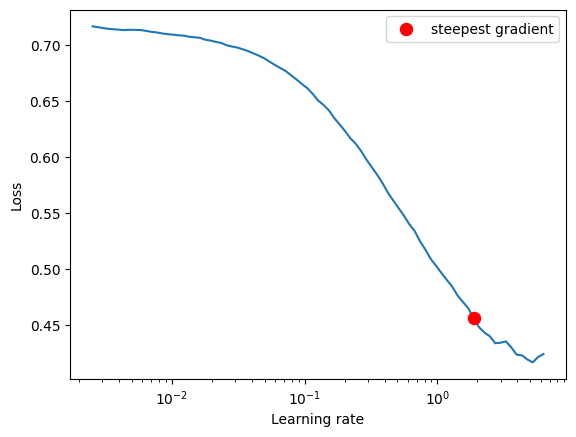

In [78]:
trainer.lr_finder_range_test(trainer.train_loader)

In [79]:
# reset learning rate based on learning rate finder
hyperparameters.LEARNING_RATE = 1.87E+00

In [80]:
# Reset Optimizer
trainer.set_optimizer(get_optimizer())

# set metric -- optional
train_metric = Accuracy(task="multilabel",num_labels=10)
trainer.set_metric(train_metric.to(device))

In [81]:
# set wandb -- OPTIONAL
trainer.set_wandb(
    project_name=project_name,
    run_name=run_name,
    config=hyperparameters,
    log_batch=True,
    log_frequency=log_frequency,
)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [82]:
trainer.sanity_check(num_classes=2)

Actual loss: 0.7165913564240327
Expected Theoretical loss: 0.6931471805599453


In [83]:
trainer.train(num_epochs=hyperparameters.EPOCHS,multilabel=True)

Validation loader is not set. The trainer will only execute training Loop
Not saving any checkpoint
Epoch 1/20 - Train Loss: 0.4043, Train Metric: 0.8084, Train Time: 0:00:10.957174
Current Learning rate is 1.87

Epoch 2/20 - Train Loss: 0.2799, Train Metric: 0.8802, Train Time: 0:00:10.776235
Current Learning rate is 1.87

Epoch 3/20 - Train Loss: 0.2292, Train Metric: 0.9102, Train Time: 0:00:09.543419
Current Learning rate is 1.87

Epoch 4/20 - Train Loss: 0.1881, Train Metric: 0.9284, Train Time: 0:00:12.001368
Current Learning rate is 1.87

Epoch 5/20 - Train Loss: 0.1402, Train Metric: 0.9536, Train Time: 0:00:14.000568
Current Learning rate is 1.87

Epoch 6/20 - Train Loss: 0.1107, Train Metric: 0.9636, Train Time: 0:00:10.919953
Current Learning rate is 1.87

Epoch 7/20 - Train Loss: 0.1004, Train Metric: 0.9684, Train Time: 0:00:08.902486
Current Learning rate is 1.87

Epoch 8/20 - Train Loss: 0.0785, Train Metric: 0.9762, Train Time: 0:00:10.986712
Current Learning rate is 1.

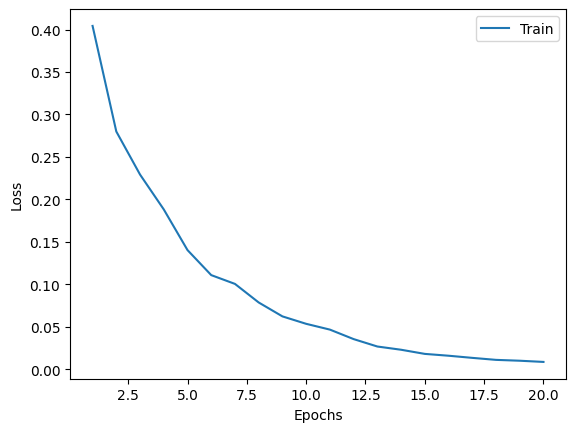

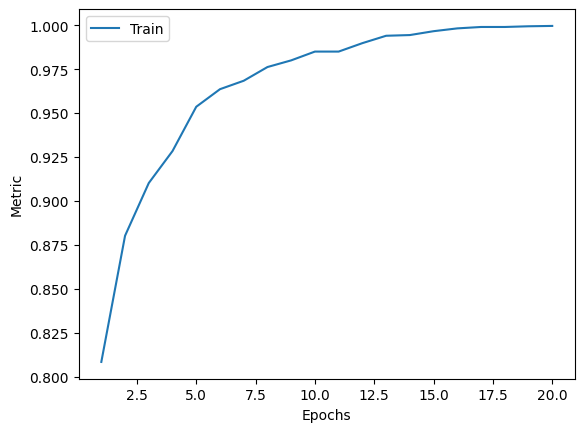

In [84]:
trainer.plot_history()

In [85]:
wandb.finish()

train_epoch_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
train_epoch_metric,▁▄▅▅▆▇▇▇▇▇▇█████████
train_epoch_loss,0.00848
train_epoch_metric,0.9996


In [71]:
%wandb jyotsna999/HW7_overfit_small_multilabel_v1

In [86]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 javascript-common libapache-pom-java
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1
  libgs9 libgs9-common libharfbuzz-icu0 libidn11 libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpdfbox-java libptexenc1 libruby2.7 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-minitest ruby-net-telnet
  ruby-power-assert ruby-test-unit ruby-xmlrpc ruby2.7 rubygems-integration
  t1utils teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-latex-base texlive-latex-extra texlive-latex-recommended
  texlive-pictures tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf

In [87]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/NLP_UTD/Assignments/Assignment_7/JyotsnaNagaprasad_Ambekar_HW7_task3_part_a.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/NLP_UTD/Assignments/Assignment_7/JyotsnaNagaprasad_Ambekar_HW7_task3_part_a.ipynb to pdf
[NbConvertApp] Support files will be in JyotsnaNagaprasad_Ambekar_HW7_task3_part_a_files/
[NbConvertApp] Making directory ./JyotsnaNagaprasad_Ambekar_HW7_task3_part_a_files
[NbConvertApp] Making directory ./JyotsnaNagaprasad_Ambekar_HW7_task3_part_a_files
[NbConvertApp] Making directory ./JyotsnaNagaprasad_Ambekar_HW7_task3_part_a_files
[NbConvertApp] Writing 51524 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 117074 bytes to /content/drive/MyDrive/NLP_UTD/Assignments/Assignment_7/JyotsnaNagaprasad_Ambekar_HW7_task3_part_a.pdf
